# Problem

**10×10 Gridworld**

**Layout (row-major indices)**

Legend: **S** start, **G** goal (terminal), **P** pit (terminal), **#** wall, **.** empty

```
r\c  0 1 2 3 4 5 6 7 8 9
0    S . . . # . . . . .
1    . # . . # . . # P .
2    . # # . . . . # . .
3    . . P . # . . # . .
4    # . # # # # # # . #
5    . . . . # . . P . .
6    . P # . # . # . . .
7    . . # . . P # . . .
8    . . # . # . # # . .
9    . . . . # . . . . G
```

**State space**

$$
\mathcal{X}={0,1,\dots,99},\quad x=10r+c
$$

* **Goal (absorbing):** $x_G=99$
* **Pits (absorbing):**
  $
  \mathcal{X}_{\text{pit}}={18,32,57,61,75,88}
  $
* **Walls (impassable):**
  $
  \mathcal{X}_{\text{wall}}={4,11,14,17,21,22,27,34,37,40,42,43,44,45,46,47,49,54,62,64,66,72,76,82,84,86,87,94}
  $

Terminal set:
$
\mathcal{T}={99}\cup \mathcal{X}_{\text{pit}}
$

**Action space**

$$
\mathcal{A}={0,1,2,3}
$$
where (0=) Up, (1=) Down, (2=) Left, (3=) Right.

**Transition dynamics (deterministic)**

Let $x\mapsto(r,c)$ by $r=\lfloor x/10\rfloor,\ c=x\bmod 10$.

* If $x\in\mathcal{T}$, then $\text{next\_state}(x,a)=x$ $absorbing$.
* Otherwise, compute the intended neighbor $(r',c')$ from action $a$.
* If $(r',c')$ is outside the grid, **stay**.
* Let $x'=10r'+c'$. If $x'\in\mathcal{X}_{\text{wall}}$, **stay**.

Transition matrix shape:
$$
P\in\mathbb{R}^{(|\mathcal{X}||\mathcal{A}|)\times|\mathcal{X}|}=\mathbb{R}^{400\times 100},
$$
with
$$
P[(x,a),x']=1 \iff x'=\text{next\_state}(x,a)
$$

**Reward model (standard step cost + terminal outcomes)**

Reward based on the **next state**:
$$
r(x,a)=
\begin{cases}
+1 & \text{if } \text{next\_state}(x,a)=99,\
-5 & \text{if } \text{next\_state}(x,a)\in \mathcal{X}_{\text{pit}},\
-0.1 & \text{otherwise.}
\end{cases}
$$

**Initial state**

$$
x_0=0.
$$

In [14]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import random
import torch
import pandas as pd
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().resolve().parent  # go to repo root
sys.path.insert(0, str(PROJECT_ROOT))

# Define dataset path
DATASET_PATH = PROJECT_ROOT / "datasets" / "10grid_wall.csv"
DATASET_PATH2 = PROJECT_ROOT / "datasets" / "10grid_wall2.csv"

from fogas_torch import PolicySolver, EnvDataCollector
from fogas_torch.algorithm import (
    FOGASSolverVectorized,
    FOGASOracleSolverVectorized,
    FOGASHyperOptimizer,
    FOGASEvaluator,
)
from fogas.dataset_collection.dataset_analyzer import DatasetAnalyzer

seed = 42
np.random.seed(seed) # Add this
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cpu


# Tabular Features

In [6]:
# ===== 10x10 Four-Rooms Grid =====

states  = torch.arange(100, dtype=torch.int64)
actions = torch.arange(4, dtype=torch.int64)
N = len(states)     # 100
A = len(actions)    # 4
gamma = 0.9

x_0 = 0  # fixed initial state

goal = 99  # absorbing terminal state

# pits (absorbing terminal states)
pits = {18, 32, 57, 61, 75}

# walls (impassable)
walls = {
    4, 11, 14, 17, 21, 22, 27, 34, 37,
    40, 42, 43, 44, 45, 46, 47, 49,
    54, 62, 64, 66, 72, 76, 82, 84, 86, 87, 94
}

# ---------- Tabular features ----------
def phi(x, a):
    vec = torch.zeros(N * A, dtype=torch.float64)
    vec[int(x) * A + int(a)] = 1.0
    return vec

# ---------- Reward weights (tabular) ----------
step_cost = -0.1
goal_reward = 1.0
pit_reward  = -5.0

omega = torch.full((N * A,), step_cost, dtype=torch.float64)

# override terminal rewards (all actions in terminal states)
omega[goal * A : goal * A + A] = goal_reward
for p in pits:
    omega[p * A : p * A + A] = pit_reward

# ---------- Helpers: index <-> (row, col) ----------
def to_rc(s):  return divmod(s, 10)
def to_s(r, c): return r * 10 + c

# ---------- Dynamics ----------
def next_state(s, a):
    # absorbing terminals
    if s == goal or s in pits:
        return s

    r, c = to_rc(s)

    if a == 0:      # Up
        r2, c2 = max(0, r - 1), c
    elif a == 1:    # Down
        r2, c2 = min(9, r + 1), c
    elif a == 2:    # Left
        r2, c2 = r, max(0, c - 1)
    elif a == 3:    # Right
        r2, c2 = r, min(9, c + 1)
    else:
        raise ValueError("Invalid action")

    sp = to_s(r2, c2)

    # wall blocks transition
    if sp in walls:
        return s

    return sp

# ---------- Backward feature map psi(x') ----------
def psi(xp):
    v = torch.zeros(N * A, dtype=torch.float64)
    for x in states:
        for a in actions:
            if next_state(int(x), int(a)) == xp:
                v[int(x) * A + int(a)] = 1.0
    return v

# ---------- Build solver ----------
mdp = PolicySolver(
    states=states,
    actions=actions,
    phi=phi,
    omega=omega,
    gamma=gamma,
    x0=x_0,
    psi=psi
)


## Oracle

In [19]:
solver = FOGASOracleSolverVectorized(
    mdp=mdp, 
    cov_matrix="identity", 
    print_params=True, 
    T=1000,
    device=device,
    seed=seed
)
evaluator = FOGASEvaluator(solver)
optimizer = FOGASHyperOptimizer(solver=solver,metric_callable=evaluator.get_metric("reward"), seed=seed)



================ FOGAS PARAMETER SUMMARY ================

Basic Information
-----------------
Dataset size n:           10000000.0
Feature norm bound R:     1.0000
Num states N:             100
Num actions A:            4
Feature dim d:            400
Discount γ:               0.9
Confidence δ:             0.05

Theoretical Quantities
----------------------
T_min (theoretical):      9255128.526390366
T (iterations):                1000   (overridden → 1000)

FOGAS Hyperparameters
---------------------
alpha:                        0.000263
rho:                            66.292053
eta:                            0.000002
D_theta:                    63.245553
beta (ridge):             0.000003
D_pi (derived):           16.651092




We do an hyperparameter optimization because is not clear how will work the Oracle in a big dimensional problem.


=== FOGAS Hyperparameter Optimization ===
[Theory] metric = 0.3761
Order: ('alpha', 'rho', 'eta')

Optimizing alpha
[After alpha*] alpha=4.7512e+00, rho=1.0000e-02, eta=1.5215e-06 | metric = 0.1000

Optimizing rho
[After rho*] alpha=4.7512e+00, rho=1.0000e-02, eta=1.5215e-06 | metric = 0.1000

Optimizing eta
[After eta*] alpha=4.7512e+00, rho=1.0000e-02, eta=3.0000e+00 | metric = 0.0432


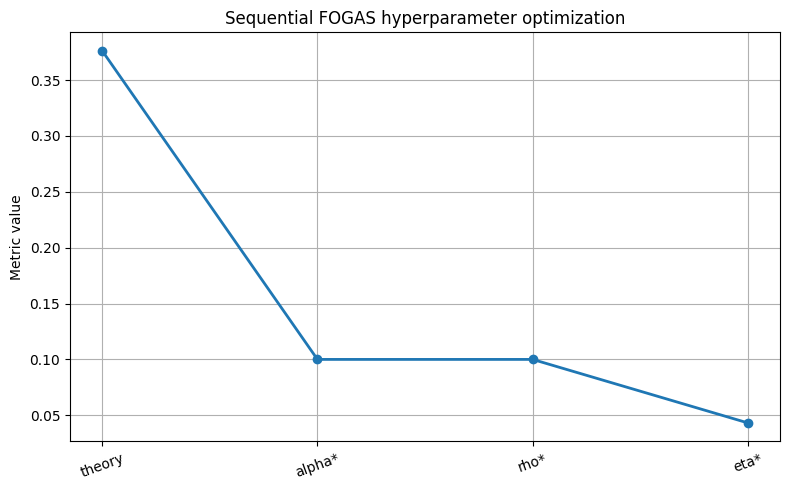

In [20]:
summary = optimizer.optimize_fogas_hyperparameters(
    search_method="random",
    coarse_points=7,
    print_main=True, 
    num_runs=1,
    random_candidates=10,
    order=("alpha", "rho", "eta"),
    bounds_overrides={"alpha" : (1e-2, 5.0), "rho" : (1e-2, 3.0), "eta" : (1e-2, 3.0)}
)

alpha_star = summary["alpha"]
rho_star = summary["rho"]
eta_star = summary["eta"]

In [21]:
solver.run(T = 10000, alpha=alpha_star, eta=eta_star, rho=rho_star, tqdm_print=True)
evaluator.print_policy()

FOGAS Oracle: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:54<00:00, 185.08it/s]

  State 0: π(a=0|s=0) = 0.00  π(a=1|s=0) = 0.41  π(a=2|s=0) = 0.00  π(a=3|s=0) = 0.59  --> best action: 3
  State 1: π(a=0|s=1) = 0.00  π(a=1|s=1) = 0.00  π(a=2|s=1) = 0.00  π(a=3|s=1) = 1.00  --> best action: 3
  State 2: π(a=0|s=2) = 0.00  π(a=1|s=2) = 0.50  π(a=2|s=2) = 0.00  π(a=3|s=2) = 0.50  --> best action: 1
  State 3: π(a=0|s=3) = 0.00  π(a=1|s=3) = 1.00  π(a=2|s=3) = 0.00  π(a=3|s=3) = 0.00  --> best action: 1
  State 4: π(a=0|s=4) = 0.00  π(a=1|s=4) = 0.00  π(a=2|s=4) = 0.00  π(a=3|s=4) = 1.00  --> best action: 3
  State 5: π(a=0|s=5) = 0.00  π(a=1|s=5) = 0.00  π(a=2|s=5) = 0.00  π(a=3|s=5) = 1.00  --> best action: 3
  State 6: π(a=0|s=6) = 0.00  π(a=1|s=6) = 0.00  π(a=2|s=6) = 0.00  π(a=3|s=6) = 1.00  --> best action: 3
  State 7: π(a=0|s=7) = 0.00  π(a=1|s=7) = 0.00  π(a=2|s=7) = 0.00  π(a=3|s=7) = 1.00  --> best action: 3
  State 8: π(a=0|s=8) = 0.00  π(a=1|s=8) = 0.00  π(a=2|s=8) = 0.00  π(a=3|s=8) = 1.00  --> best action: 3
  State 9: π(a=0|s=9) = 0.00  π(a=1|s=9) = 1.0

Let's do an easy check that the policy achieves the goal in a optimal way:

In [22]:
evaluator.print_optimal_path(goal_state=99)


  OPTIMAL PATH VISUALIZATION - Learned Policy (π_FOGAS)

Initial State: 0
Goal State: 99
Discount Factor (γ): 0.9

----------------------------------------------------------------------

  Step   0 │ State: 0        │ Action: 3       │ Reward:  -0.100 │ → 1
  Step   1 │ State: 1        │ Action: 3       │ Reward:  -0.100 │ → 2
  Step   2 │ State: 2        │ Action: 1       │ Reward:  -0.100 │ → 12
  Step   3 │ State: 12       │ Action: 3       │ Reward:  -0.100 │ → 13
  Step   4 │ State: 13       │ Action: 1       │ Reward:  -0.100 │ → 23
  Step   5 │ State: 23       │ Action: 3       │ Reward:  -0.100 │ → 24
  Step   6 │ State: 24       │ Action: 3       │ Reward:  -0.100 │ → 25
  Step   7 │ State: 25       │ Action: 0       │ Reward:  -0.100 │ → 15
  Step   8 │ State: 15       │ Action: 0       │ Reward:  -0.100 │ → 5
  Step   9 │ State: 5        │ Action: 3       │ Reward:  -0.100 │ → 6
  Step  10 │ State: 6        │ Action: 3       │ Reward:  -0.100 │ → 7
  Step  11 │ State: 7    

## Empirical

### Dataset Collection

In [9]:
# Initialize the collector with these options
collector = EnvDataCollector(
    mdp=mdp,
    env_name="10grid_wall",
    reset_probs={'custom': 1.0},
    max_steps=50,
    seed=seed
)

In [ ]:
# Create an epsilon-greedy pi_star (30% optimal, 70% random)
epsilon_policy = (mdp.pi_star, 0.3)

# Use it in your mixed collection as before
collector.collect_mixed_dataset(
    policies=[epsilon_policy, "random"],  
    proportions=[0.8, 0.2],
    n_steps=8000,
    episode_based=True,                   
    save_path=str(DATASET_PATH),
    verbose=True
)


  MIXED DATASET COLLECTION SUMMARY (TORCH)
Total transitions: 8000
Total episodes: 242
Mode: Episode-based

Policy Distribution:
  Policy 0:  6047 steps (75.6%) | Target: 80.0% | Episodes: 194
  Policy 1:  1953 steps (24.4%) | Target: 20.0% | Episodes: 49

✅ Mixed dataset saved to: /shared/home/mauro.diaz/work/FOGAS/datasets/10grid_wall.csv


,episode,step,state,action,reward,next_state,policy_id
0,0,0,0,0,-0.1,0,0
1,0,1,0,3,-0.1,1,0
2,0,2,1,3,-0.1,2,0
3,0,3,2,1,-0.1,12,0
4,0,4,12,3,-0.1,13,0
...,...,...,...,...,...,...,...
7995,242,9,3,3,-0.1,3,1
7996,242,10,3,2,-0.1,2,1
7997,242,11,2,0,-0.1,2,1
7998,242,12,2,0,-0.1,2,1


In [8]:
analyzer = DatasetAnalyzer(DATASET_PATH)

analyzer.summary()

Dataset Analysis Summary
Source: /home/mauro/Desktop/EMAI/Ljubljana/Thesis/Code/datasets/10grid_wall.csv
Total transitions: 8,000
Unique (state, action) pairs: 195
Unique states visited: 53
Unique actions taken: 4
--------------------------------------------------
Pair Frequency Statistics:
  Min count:    1
  Max count:    300
  Mean count:   41.03
  Std count:    62.54
  Median count: 17.0


### Solving it

In [7]:
solver_e = FOGASSolverVectorized(
    mdp=mdp,
    csv_path=str(DATASET_PATH),
    device=device,
    seed=seed)
evaluator_e = FOGASEvaluator(solver_e)
optimizer_e = FOGASHyperOptimizer(solver=solver_e,metric_callable=evaluator_e.get_metric("reward"), seed=seed)

In [82]:
# Run solver with best alpha and fixed rho, eta
solver_e.run(alpha=0.001 / 2, eta=0.0002, rho=0.05, tqdm_print=True, T=12000)
evaluator_e.print_policy()

FOGAS: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 12000/12000 [00:17<00:00, 681.63it/s]


  State 0: π(a=0|s=0) = 0.13  π(a=1|s=0) = 0.17  π(a=2|s=0) = 0.12  π(a=3|s=0) = 0.58  --> best action: 3
  State 1: π(a=0|s=1) = 0.13  π(a=1|s=1) = 0.14  π(a=2|s=1) = 0.05  π(a=3|s=1) = 0.68  --> best action: 3
  State 2: π(a=0|s=2) = 0.14  π(a=1|s=2) = 0.63  π(a=2|s=2) = 0.06  π(a=3|s=2) = 0.18  --> best action: 1
  State 3: π(a=0|s=3) = 0.25  π(a=1|s=3) = 0.46  π(a=2|s=3) = 0.09  π(a=3|s=3) = 0.20  --> best action: 1
  State 4: π(a=0|s=4) = 0.25  π(a=1|s=4) = 0.25  π(a=2|s=4) = 0.25  π(a=3|s=4) = 0.25  --> best action: 0
  State 5: π(a=0|s=5) = 0.15  π(a=1|s=5) = 0.07  π(a=2|s=5) = 0.13  π(a=3|s=5) = 0.65  --> best action: 3
  State 6: π(a=0|s=6) = 0.11  π(a=1|s=6) = 0.07  π(a=2|s=6) = 0.07  π(a=3|s=6) = 0.75  --> best action: 3
  State 7: π(a=0|s=7) = 0.13  π(a=1|s=7) = 0.09  π(a=2|s=7) = 0.06  π(a=3|s=7) = 0.73  --> best action: 3
  State 8: π(a=0|s=8) = 0.11  π(a=1|s=8) = 0.03  π(a=2|s=8) = 0.05  π(a=3|s=8) = 0.81  --> best action: 3
  State 9: π(a=0|s=9) = 0.10  π(a=1|s=9) = 0.7

In [83]:
evaluator_e.print_optimal_path(goal_state=99)


  OPTIMAL PATH VISUALIZATION - Learned Policy (π_FOGAS)

Initial State: 0
Goal State: 99
Discount Factor (γ): 0.9

----------------------------------------------------------------------

  Step   0 │ State: 0        │ Action: 3       │ Reward:  -0.100 │ → 1
  Step   1 │ State: 1        │ Action: 3       │ Reward:  -0.100 │ → 2
  Step   2 │ State: 2        │ Action: 1       │ Reward:  -0.100 │ → 12
  Step   3 │ State: 12       │ Action: 3       │ Reward:  -0.100 │ → 13
  Step   4 │ State: 13       │ Action: 1       │ Reward:  -0.100 │ → 23
  Step   5 │ State: 23       │ Action: 3       │ Reward:  -0.100 │ → 24
  Step   6 │ State: 24       │ Action: 3       │ Reward:  -0.100 │ → 25
  Step   7 │ State: 25       │ Action: 0       │ Reward:  -0.100 │ → 15
  Step   8 │ State: 15       │ Action: 3       │ Reward:  -0.100 │ → 16
  Step   9 │ State: 16       │ Action: 0       │ Reward:  -0.100 │ → 6
  Step  10 │ State: 6        │ Action: 3       │ Reward:  -0.100 │ → 7
  Step  11 │ State: 7   

## Data Analysis

**What “alignment-based coverage” looks like in this tabular case**

FOGAS’ key coverage term is the **feature coverage ratio**
$$
|\lambda_{\pi^*}|_{\Lambda_n^{-1}}^2
$$
(and this measures how well the dataset covers the comparator policy in feature space). 

With one-hot features, the empirical covariance
$$
\Lambda_n = \beta I + \frac{1}{n}\sum_{i=1}^n \phi_i\phi_i^\top
$$
is **diagonal**, and each diagonal entry corresponds to a particular $(x,a)$:
$$
(\Lambda_n)_{(x,a),(x,a)} = \beta + \frac{N(x,a)}{n}.
$$
(Here $N(x,a)$ is how often $(x,a)$ appears in the dataset.) 

Because it’s diagonal, the coverage ratio becomes:
$$
|\lambda_{\pi^*}|_{\Lambda_n^{-1}}^2 =
\sum_{x,a}\frac{\mu_{\pi^*}(x,a)^2}{\beta + N(x,a)/n}.
$$

So **alignment-based coverage** (in tabular) literally means:

- The dataset counts $N(x,a)$ are large exactly on the $(x,a)$ where $\mu_{\pi^*}(x,a)$ is large.


In [13]:
ratio = analyzer.feature_coverage_ratio(
    mdp=mdp,
    beta=solver_e.params.beta,
    use_optimal_policy=True,
    verbose=True,
    return_details=True,
)


Feature Coverage Ratio Details
------------------------------
  Dataset size (n):         8000
  MDP dims (N, A, d):        (100, 4, 400)
  gamma:                    0.9
  beta (ridge):             3.3761e-07
  policy source:            provided

  Occupancy μ_pi summary:
    sum:                    1
    min / max:              0 / 0.1

  Feature occupancy λ_pi summary:
    ||λ||_2:                0.242197
    ||λ||_1:                1
    max |λ_i|:              0.1

  Empirical covariance Λ_n:
    diag min / mean / max:  3.3761e-07 / 0.00250034 / 0.0375003
    eig min / max:          3.3761e-07 / 0.0375003
    condition number:       111076

  Coverage ratio:           18849.2


In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
# Use standard text-based tqdm to avoid ipywidgets/IProgress errors
from tqdm import tqdm

# --- 1. Define Grid Search Parameters ---
# Vary dataset sizes around your baseline of 8000
dataset_sizes = [8000, 12000, 16000, 20000, 24000]

# Vary epsilon for the epsilon-greedy policy (prob of random action)
epsilon_values = [0.3, 0.4, 0.5, 0.6, 0.7]

# Vary proportions: [Epsilon-Greedy, Random]
# Note: Epsilon-Greedy already has randomness, but this mixes it with pure Random policy
proportion_configs = [
    ([1.0, 0], "100% Eps-Greedy / 0% Random"),
    ([0.9, 0.1], "90% Eps-Greedy / 10% Random"),
    ([0.8, 0.2], "80% Eps-Greedy / 20% Random"),
    ([0.7, 0.3], "70% Eps-Greedy / 30% Random"),
]

# Attempt to retrieve beta from solver (solver_e or solver)
try:
    # Try the name 'solver_e'
    beta_val = solver_e.params.beta
except NameError:
    try:
        # Try the name 'solver' (common in your previous cells)
        beta_val = solver.params.beta
    except:
        print("Warning: Could not find 'solver_e' or 'solver' for beta. Using default 1e-4.")
        beta_val = 1e-4

# Ensure beta is a float (converts from tensor if needed)
if hasattr(beta_val, "item"):
    beta_val = beta_val.item()
beta_val = float(beta_val)

print(f"Running Grid Search with beta={beta_val:.2e} ...")

# Create temp directory
temp_dir = "temp_datasets_grid_search"
os.makedirs(temp_dir, exist_ok=True)

results = []

# --- 2. Grid Search Loop ---
# Calculate total iterations for progress bar
total_iters = len(dataset_sizes) * len(epsilon_values) * len(proportion_configs)

# Use text-based tqdm
with tqdm(total=total_iters, desc="Grid Search") as pbar:
    for props, prop_label in proportion_configs:
        for eps in epsilon_values:
            # Policy is a tuple: (Optimal Policy Matrix, epsilon)
            # Assuming mdp.pi_star exists
            epsilon_policy = (mdp.pi_star, eps)
            
            for n_steps in dataset_sizes:
                # Unique filename for this run
                fname = f"data_n{n_steps}_eps{eps}_p{int(props[0]*100)}.csv"
                save_path = os.path.join(temp_dir, fname)
                
                # 1. Collect Dataset
                # Clean up previous file if it exists
                if os.path.exists(save_path):
                    os.remove(save_path)
                    
                collector.collect_mixed_dataset(
                    policies=[epsilon_policy, "random"],
                    proportions=props,
                    n_steps=n_steps,
                    episode_based=True,
                    save_path=save_path,
                    verbose=False
                )
                
                # 2. Analyze Coverage Ratio
                try:
                    # Using the Analyzer to compute coverage
                    analyzer_instance = DatasetAnalyzer(save_path)
                    
                    ratio = analyzer_instance.feature_coverage_ratio(
                        mdp=mdp,
                        beta=beta_val,
                        use_optimal_policy=True,
                        verbose=False, # Reduce noise
                        return_details=False
                    )
                except Exception as e:
                    print(f"Error analyzing {fname}: {e}")
                    ratio = np.nan
                
                # 3. Store Result
                results.append({
                    "Dataset Size": n_steps,
                    "Epsilon": eps,
                    "Proportions": prop_label,
                    "Coverage Ratio": ratio
                })
                
                # Cleanup: remove temp file to save space
                if os.path.exists(save_path):
                    os.remove(save_path)
                    
                pbar.update(1)

# --- 3. Plotting Results ---
if results:
    df_res = pd.DataFrame(results)
    
    # Setup plot style
    sns.set_theme(style="whitegrid")
    
    # Create FacetGrid: columns by Proportions, Color by Epsilon
    g = sns.FacetGrid(df_res, col="Proportions", hue="Epsilon", height=5, aspect=1.2, sharey=True)
    g.map(sns.lineplot, "Dataset Size", "Coverage Ratio", marker="o", linewidth=2.5)
    
    # Polish axes and legends
    g.add_legend(title="Epsilon (ε)")
    g.set_axis_labels("Dataset Size", "Coverage Ratio")
    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle(f"Feature Coverage Ratio vs Dataset Size (beta={beta_val:.2e})", fontsize=16)
    
    # Set x-ticks to match sampled sizes
    for ax in g.axes.flat:
        ax.set_xticks(dataset_sizes)
        
    plt.show()
    
    # Display top results
    print("\nBest Configurations (Lowest Coverage Ratio):")
    print(df_res.sort_values(by="Coverage Ratio", ascending=True).head(5))
else:
    print("No results generated.")

Running Grid Search with beta=3.38e-07 ...


Grid Search:   1%|          | 1/100 [00:03<05:02,  3.06s/it]

Grid Search:  17%|█▋        | 17/100 [03:30<17:07, 12.38s/it]


KeyboardInterrupt: 